# Custom metrics

Refs:
* https://twitter.com/fchollet/status/1280730971717820416/photo/1
* https://neptune.ai/blog/keras-metrics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

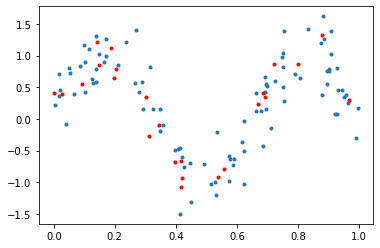

In [2]:
# Cook some simplistic data:
np.random.seed(1)
n_points = 120
x = np.random.uniform(size=n_points)
y = np.sin(x*3*np.pi) + np.random.normal(size=x.shape)/3

ind = list(range(np.round(n_points*0.2).astype(int)))
xtest = x[ind]
ytest = y[ind]
x = x[[i for i in range(n_points) if i not in ind ]]
y = y[[i for i in range(n_points) if i not in ind ]]

plt.plot(x,y,'.');
plt.plot(xtest, ytest, 'r.');

In [3]:
# Custom callback, to see what's happening during the training
# https://www.tensorflow.org/guide/keras/custom_callback

class CustomCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 20 == 0:
            print(f"{logs['loss']:0.3}", end=' ')

In [102]:
# Custom metrics

class custom_metric(tf.keras.metrics.Metric):      # Inherit to base class
    def __init__(self, name='custom_metric', **kwargs):    # I think we need to have a matching interface, right?
        super().__init__(name=name, **kwargs)
        self.myvalue = self.add_weight(name='custom_value', initializer='zeros', dtype='float')
        self.nsamples = self.add_weight(name='nsamples',    initializer='zeros', dtype='int32')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        """Whatever we initialized, here we do the for one pair of (true, predicted) y."""
        #y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        #y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        val = tf.reduce_sum(tf.abs(y_true - y_pred))
        self.myvalue.assign_add(val)
        self.nsamples.assign_add(tf.shape(y_pred)[0])
    
    def result(self):
        """Here we return loss."""
        return self.myvalue/tf.cast(self.nsamples, tf.float32)
        # TF is more stricts about types, and requires that var types match for arithmetics
        # (Coz of course all simple arithmetic operators are overridden for TF objects)
    
    def reset_states(self):
        """Reset states to 0."""
        self.myvalue.assign(0)
        self.nsamples.assign(0)

In [110]:
def make_model(size=None, learning_rate=0.002):
    # Let's build a model of leakyReLU units, so that we could have layer width==1, and still have gradients.
    # This woudl be useful for testing different shapes.
    # LeakyReLU cannot be set as a layer activation, it appears, but can be a separate layer.
    if size is None:
        size = (32, 32)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)), # https://www.tensorflow.org/api_docs/python/tf/keras/Input
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(loss='mean_squared_error',
                 optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 #metrics=['mean_squared_error']
                 metrics=[custom_metric()]
                 )
    return model

model = make_model((8,89))
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 32)                64        
_________________________________________________________________
dense_112 (Dense)            (None, 128)               4224      
_________________________________________________________________
dense_113 (Dense)            (None, 1)                 129       
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


0.536 0.454 0.33 0.219 0.208 

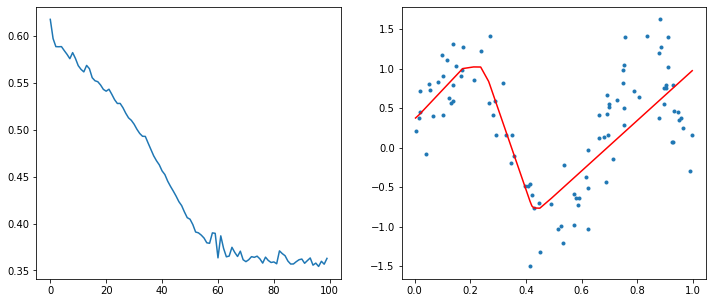

In [111]:
# Manual fit
history = model.fit(x, y,
                    batch_size=16,
                    epochs=100,
                    verbose=0,
                    callbacks=[CustomCallbacks()],
                    validation_data=(xtest, ytest) # Keeping this commented makes everything faster
                   )

plt.figure(figsize=(12,5))
plt.subplot(121)
#plt.plot(history.history['loss']);
plt.plot(history.history['custom_metric'])
#plt.plot(history.history['val_loss']);
    
plt.subplot(122)
y_new = model.predict(x)
plt.plot(x,y, '.');
ind = np.argsort(x)
plt.plot(x[ind], y_new[ind], 'r-');